In [1]:
import random
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import unidecode
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
import numpy as np

nltk.download('stopwords') #import stopwords
nltk.download('punkt_tab') #import punkt_tab
nltk.download('wordnet') #import wordnet
random.seed(75008) #fixed random seed based on class number and group number

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\shrek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Set the path to the file you'd like to load
file_path = "socialmedia-disaster-tweets-DFE.csv"

# Load the latest version of file from kaggle
DisasterTweetsDF = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "szelee/disasters-on-social-media",
  file_path,
  pandas_kwargs={"usecols": ['_unit_id','text','choose_one']}
)


In [3]:
DisasterTweetsDF.describe(include='all') #check completion and uniqueness of dataset

,_unit_id,choose_one,text
count,1.087600e+04,10876,10876
unique,NaN,3,10678
top,NaN,Not Relevant,11-Year-Old Boy Charged With Manslaughter of T...
freq,NaN,6187,13
mean,7.782503e+08,NaN,NaN
std,3.200574e+03,NaN,NaN
min,7.782438e+08,NaN,NaN
25%,7.782475e+08,NaN,NaN
50%,7.782503e+08,NaN,NaN
75%,7.782530e+08,NaN,NaN


In [4]:
print(DisasterTweetsDF['choose_one'].unique()) #expected binary classification in choose_one, investigate discrepancy

['Relevant' 'Not Relevant' "Can't Decide"]


In [5]:
DisasterTweetsDF = DisasterTweetsDF[DisasterTweetsDF.choose_one != "Can't Decide"] #remove unclassified records they will not be useful for training or testing
DisasterTweetsDF = DisasterTweetsDF.reset_index(drop=True) #reset index to prevent issues

In [6]:
stop_words = set(stopwords.words('english')) #define stopwords set
stop_words.add('http') #add http to stopwords
stop_words.add('https') #add https to stopwords
stop_words.add('www') #add www to stopwords
stemmer=PorterStemmer() #initialize stemmer
lemmatizer=WordNetLemmatizer() #initialize lemmatizer
DisasterTweetsDF['clean_list']='' #create column for cleansed text
for i in DisasterTweetsDF.index: #iterate across all records in dataframe
    word_tokens = DisasterTweetsDF.iloc[i,2].strip()
    word_tokens = word_tokens.replace("å«", "'") # Step to correct for corruptec characters due to encoding errors
    word_tokens = word_tokens.replace("amp;amp;", "amp;") # Step to correct for corruptec characters due to encoding errors
    word_tokens = word_tokens.replace("&amp;", "&") # Step to correct for corruptec characters due to encoding errors
    word_tokens = word_tokenize(word_tokens)#parse text into tokens
    clean_tokens = [] #intialize variable to hold cleansed text
    for word in word_tokens: #iterate across all word tokens
        word = word.replace("‰Û_", " ") # Step to correct for corruptec characters due to encoding errors, this is an ellipsis, not useful character
        word = word.replace("rÌ_", "ru") # Step to correct for corruptec characters due to encoding errors
        word = word.replace("pÌ_", "po") # Step to correct for corruptec characters due to encoding errors
        word = word.replace("vÌ_", "vi") # Step to correct for corruptec characters due to encoding errors
        word = word.replace("‰Û\x9d", ' ') # Step to correct for corruptec characters due to encoding errors, this is double right end qoute, not useful character
        word = word.replace("å_", ' ') # Step to correct for corruptec characters due to encoding errors, this is broken bar, not useful character
        word = word.replace("\x81_", "z") # Step to correct for corruptec characters due to encoding errors
        word = word.encode('Windows-1252') # Step to correct for corrupted characters due to encoding errors
        word = word.decode('mac-roman').encode('Windows-1252', 'replace') # Step to correct for corrupted characters due to encoding errors
        word = word.decode('utf-8') # Step to correct for corrupted characters due to encoding errors
        word = unidecode.unidecode(word,'utf-8') #remove accented characters
        word = word.lower() #set all characters to lowercase
        word = word.strip() #remove any leading/trailing whitespace
        word = re.sub('//t.co/.*', '', word) #remove any word token that is a twitter shortened url
        word = word.translate(str.maketrans(string.digits,len(string.digits)*' ')) #replace all digits with whitespace
        word = word.translate(str.maketrans(string.punctuation,len(string.punctuation)*' ')) #replace all punctuation with whitespace
        word_token = word_tokenize(word) #retokenize word based on new whitespaces
        word_token = [word for word in word_token if not word in stop_words] #keep only non-stopwords
        for word in word_token:#iterate across all word_token sub tokens
            w1 = stemmer.stem(word) #stem sub tokens
            w2 = lemmatizer.lemmatize(word)#lemmatize sub tokens
            if not word in stop_words and len(word)>2: #check if stemmed/lemmatized sub token is a stop word and of material length
                clean_tokens = clean_tokens+[w2] #append non stop words to list of clean tokens
    DisasterTweetsDF.iat[i,3] = clean_tokens #join all cleaned tokens into new clean_text column
DisasterTweetsDF['clean_text']=DisasterTweetsDF.clean_list.apply(' '.join)

In [7]:
DisasterTweetsDF['target'] = np.where(DisasterTweetsDF['choose_one'] == 'Relevant', 1, 0)
X=DisasterTweetsDF[['_unit_id','clean_list','clean_text','target']]
Y=DisasterTweetsDF[['target']]
train, test = train_test_split(X, test_size=0.2, random_state=75008, stratify=Y) #parse and stratify predictors and targets into training and test datasets
train = train.reset_index(drop=True) #reset index to prevent issues
test = test.reset_index(drop=True) #reset index to prevent issues

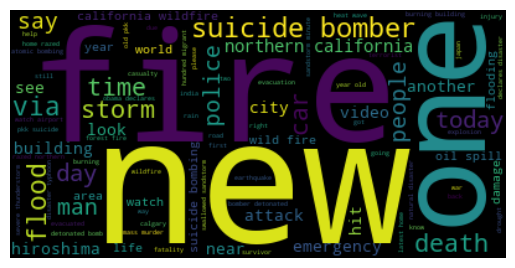

In [8]:
Total_tokens = ''
comment_words = ''

for i in range(len(train)):
    if train.iloc[i,3] == 1: 
        l2 = len(train.iloc[i,1])
        for j in range(l2):
            Total_tokens = Total_tokens+' '+train.iloc[i,1][j]
wordcloud = WordCloud().generate(Total_tokens)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

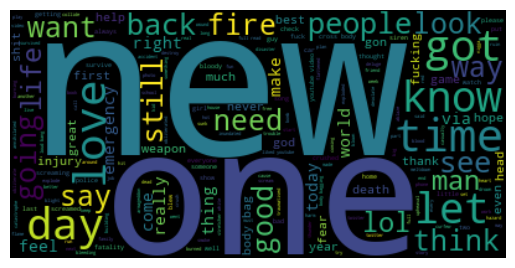

In [9]:
Total_tokens = ''
comment_words = ''

for i in range(len(train)):
    if train.iloc[i,3] == 0: 
        l2 = len(train.iloc[i,1])
        for j in range(l2):
            Total_tokens = Total_tokens+' '+train.iloc[i,1][j]
wordcloud = WordCloud().generate(Total_tokens)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
y_train=train['target']
y_test=test['target']

model_results=pd.DataFrame(columns=['model','classifier','params','precision','recall','accuracy','f1'])

def W2V_training(sgs,vector_len,windows,counts,epoch):
    W2V_model = Word2Vec(train['clean_list'],vector_size=vector_len,window=windows,min_count=counts,sg=sgs)
    W2V_model.build_vocab(corpus_iterable=train['clean_list'],progress_per=1000)
    W2V_model.train(train['clean_list'], total_examples=W2V_model.corpus_count, epochs=epoch)
    
    words_W2V = set(W2V_model.wv.index_to_key)
    train['vectors_W2V'] = ''
    for i in train.index: #iterate across all records in dataframe
        s = train.iloc[i,1]
        arrays=[]
        for w in s:
            if w in words_W2V:
                arrays=arrays+[W2V_model.wv[w]]
        if len(arrays)==0:
            arrays=np.zeros(shape=(1,vector_len))
        vectors=np.mean(arrays, axis=0)
        train.iat[i,4]=vectors
    
    test['vectors_W2V'] = ''
    for i in test.index: #iterate across all records in dataframe
        s = test.iloc[i,1]
        arrays=[]
        for w in s:
            if w in words_W2V:
                arrays=arrays+[W2V_model.wv[w]]
        if len(arrays)==0:
            arrays=np.zeros(shape=(1,vector_len))
        vectors=np.mean(arrays, axis=0)
        test.iat[i,4]=vectors
    
    #Build random forest model for W2V
    rf = RandomForestClassifier()
    x_train_W2V=train['vectors_W2V'].tolist()
    rf_W2V_model = rf.fit(x_train_W2V, y_train.values.ravel())
    y_pred_rf_W2V = rf_W2V_model.predict(test['vectors_W2V'].tolist())
    precision = precision_score(y_test, y_pred_rf_W2V)
    recall = recall_score(y_test, y_pred_rf_W2V)
    f1 = (2 * precision * recall ) / (precision + recall)

    model_results.loc[len(model_results)] = ["W2V", 'RF', 'sg: {} / vector_sizing: {} / window_sizing: {} / min_count: {} / epoch: {}'.format(sgs,vector_len,windows,counts,epoch),round(precision, 3), round(recall, 3), round((y_pred_rf_W2V==y_test).sum()/len(y_pred_rf_W2V), 3),round(f1,3)]

In [30]:
sg=[2] #iterated through 0-2 for initial setting
vector_sizing=[200] #iterated by 50 from 100-300 for initial setting
window_sizing=[4] #iterated 2-5 for initial setting
min_count=[1] #iterated 1-3 for initial setting
epoch=[20] #iterated 10 and 20 for initial setting

for i in sg:
    for j in vector_sizing:
        for k in window_sizing:
            for l in min_count:
                for m in epoch:
                    W2V_training(i, j, k, l, m)

In [31]:
print(model_results.sort_values(by=['f1'], ascending=False))

    model classifier                                             params  \
151   W2V         RF  sg: 2 / vector_sizing: 200 / window_sizing: 4 ...   
79    W2V         RF  sg: 1 / vector_sizing: 150 / window_sizing: 4 ...   
112   W2V         RF  sg: 1 / vector_sizing: 300 / window_sizing: 3 ...   
166   W2V         RF  sg: 2 / vector_sizing: 250 / window_sizing: 5 ...   
108   W2V         RF  sg: 1 / vector_sizing: 250 / window_sizing: 5 ...   
..    ...        ...                                                ...   
52    W2V         RF  sg: 0 / vector_sizing: 300 / window_sizing: 3 ...   
55    W2V         RF  sg: 0 / vector_sizing: 300 / window_sizing: 4 ...   
40    W2V         RF  sg: 0 / vector_sizing: 250 / window_sizing: 3 ...   
28    W2V         RF  sg: 0 / vector_sizing: 200 / window_sizing: 3 ...   
25    W2V         RF  sg: 0 / vector_sizing: 200 / window_sizing: 2 ...   

     precision  recall  accuracy     f1  
151      0.808   0.682     0.793  0.740  
79       0.814 

In [46]:
print(model_results.iloc[151,2])

sg: 2 / vector_sizing: 200 / window_sizing: 4 / min_count: 1 / epoch: 20
